<a href="https://colab.research.google.com/github/gRedDeer/kaggle_notebooks/blob/main/PS4E10_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

playground_series_s4e10_path = kagglehub.competition_download('playground-series-s4e10')
chilledwanker_loan_approval_prediction_path = kagglehub.dataset_download('chilledwanker/loan-approval-prediction')

print('Data source import complete.')


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.base import clone
from sklearn.pipeline import Pipeline
import gc
import xgboost as xgb
from xgboost import XGBClassifier,XGBRFClassifier, DMatrix, plot_importance as xgb_plot_importance
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier, plot_importance
from lightgbm.callback import early_stopping
import warnings

warnings.filterwarnings('ignore')

from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import Ridge


In [ ]:
train_df = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv', index_col='id')
test_df = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv', index_col='id')
orig_df = pd.read_csv('/kaggle/input/loan-approval-prediction/credit_risk_dataset.csv')

In [ ]:
orig_df.index
train_df = pd.concat([train_df, orig_df])
train_df = train_df.reset_index(drop=True)
train_df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91226 entries, 0 to 91225
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  91226 non-null  int64  
 1   person_income               91226 non-null  int64  
 2   person_home_ownership       91226 non-null  object 
 3   person_emp_length           90331 non-null  float64
 4   loan_intent                 91226 non-null  object 
 5   loan_grade                  91226 non-null  object 
 6   loan_amnt                   91226 non-null  int64  
 7   loan_int_rate               88110 non-null  float64
 8   loan_percent_income         91226 non-null  float64
 9   cb_person_default_on_file   91226 non-null  object 
 10  cb_person_cred_hist_length  91226 non-null  int64  
 11  loan_status                 91226 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 8.4+ MB


In [ ]:
train_df.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
loan_status                      0
dtype: int64

# **EDA & Feature Engineering**

&nbsp;

In [ ]:
#fixing nan values with means
train_df['loan_int_rate'] = train_df['loan_int_rate'].fillna(train_df['loan_int_rate'].mean())
train_df['person_emp_length'] = train_df['person_emp_length'].fillna(train_df['person_emp_length'].mean())

In [ ]:
#adding some new features
for df in [train_df, test_df]:
  df['partial_net_worth'] = df['person_income'] * df['person_emp_length']
  df['monthly_debt'] = (df['loan_amnt'] * (1 + df['loan_int_rate'].astype(float)) / 12)

In [ ]:
#extracting targets to plot features
target = train_df['loan_status']
features = train_df.drop('loan_status', axis=1).columns.tolist()

In [ ]:
#listing numerical & categorical features
cat_features = train_df.select_dtypes(include='object').columns.tolist()
num_features = list(set(features) - set(cat_features))

In [ ]:
#quick data view
train_df.describe(include='all').T.sort_values(by='unique')

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
cb_person_default_on_file,91226,2,N,76779,NaN,NaN,NaN,NaN,NaN,NaN,NaN
person_home_ownership,91226,4,RENT,47040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_intent,91226,6,EDUCATION,18724,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_grade,91226,7,A,31761,NaN,NaN,NaN,NaN,NaN,NaN,NaN
person_age,91226.0,NaN,NaN,NaN,27.61648,6.148115,20.0,23.0,26.0,30.0,144.0
person_income,91226.0,NaN,NaN,NaN,64770.706224,47936.961097,4000.0,40000.0,57000.0,78000.0,6000000.0
person_emp_length,91226.0,NaN,NaN,NaN,4.732119,4.005274,0.0,2.0,4.0,7.0,123.0
loan_amnt,91226.0,NaN,NaN,NaN,9350.348607,5848.605423,500.0,5000.0,8000.0,12000.0,35000.0
loan_int_rate,91226.0,NaN,NaN,NaN,10.789508,3.055439,5.42,7.88,10.789508,12.99,23.22
loan_percent_income,91226.0,NaN,NaN,NaN,0.163154,0.097491,0.0,0.09,0.14,0.22,0.83


In [ ]:
for col in cat_features:
    display(train_df.groupby(col)[['loan_amnt', 'loan_int_rate']].agg(['min', 'mean', 'max']))

loan_amnt                      loan_int_rate             \
                            min          mean    max           min       mean   
person_home_ownership                                                           
MORTGAGE                    500  10177.988136  35000          5.42  10.154897   
OTHER                      1000  10599.617347  25000          5.79  11.735222   
OWN                         900   8871.172667  35000          5.42  10.773927   
RENT                        500   8730.129188  35000          5.42  11.303732   

                              
                         max  
person_home_ownership         
MORTGAGE               22.48  
OTHER                  20.52  
OWN                    21.27  
RENT                   23.22

loan_amnt                      loan_int_rate             \
                        min          mean    max           min       mean   
loan_intent                                                                 
DEBTCONSOLIDATION       500   9311.842105  35000          5.42  10.740802   
EDUCATION               700   9200.219344  35000          5.42  10.768989   
HOMEIMPROVEMENT         500  10273.793121  35000          5.42  10.985154   
MEDICAL                 500   8976.930315  35000          5.42  10.846264   
PERSONAL                500   9358.476540  35000          5.42  10.739256   
VENTURE                 500   9379.518436  35000          5.42  10.723682   

                          
                     max  
loan_intent               
DEBTCONSOLIDATION  22.11  
EDUCATION          21.74  
HOMEIMPROVEMENT    23.22  
MEDICAL            21.74  
PERSONAL           22.06  
VENTURE            23.22

loan_amnt                      loan_int_rate                  
                 min          mean    max           min       mean    max
loan_grade                                                               
A                500   8478.378357  35000      5.420000   7.441947  19.04
B                500   9748.841431  35000      5.990000  11.014408  17.56
C                500   9085.190637  35000      5.790000  13.396767  16.29
D               1000  10658.709007  35000      6.000000  15.221815  19.13
E               1000  12537.645717  35000      6.000000  16.707653  23.06
F               1200  13997.756410  35000     10.789508  18.068479  22.06
G               1500  15618.298969  35000     10.789508  19.789665  23.22

loan_amnt                     loan_int_rate  \
                                min         mean    max           min   
cb_person_default_on_file                                               
N                               500  9276.934865  35000          5.42   
Y                               750  9740.508064  35000          5.99   

                                             
                                mean    max  
cb_person_default_on_file                    
N                          10.135789  21.74  
Y                          14.263717  23.22

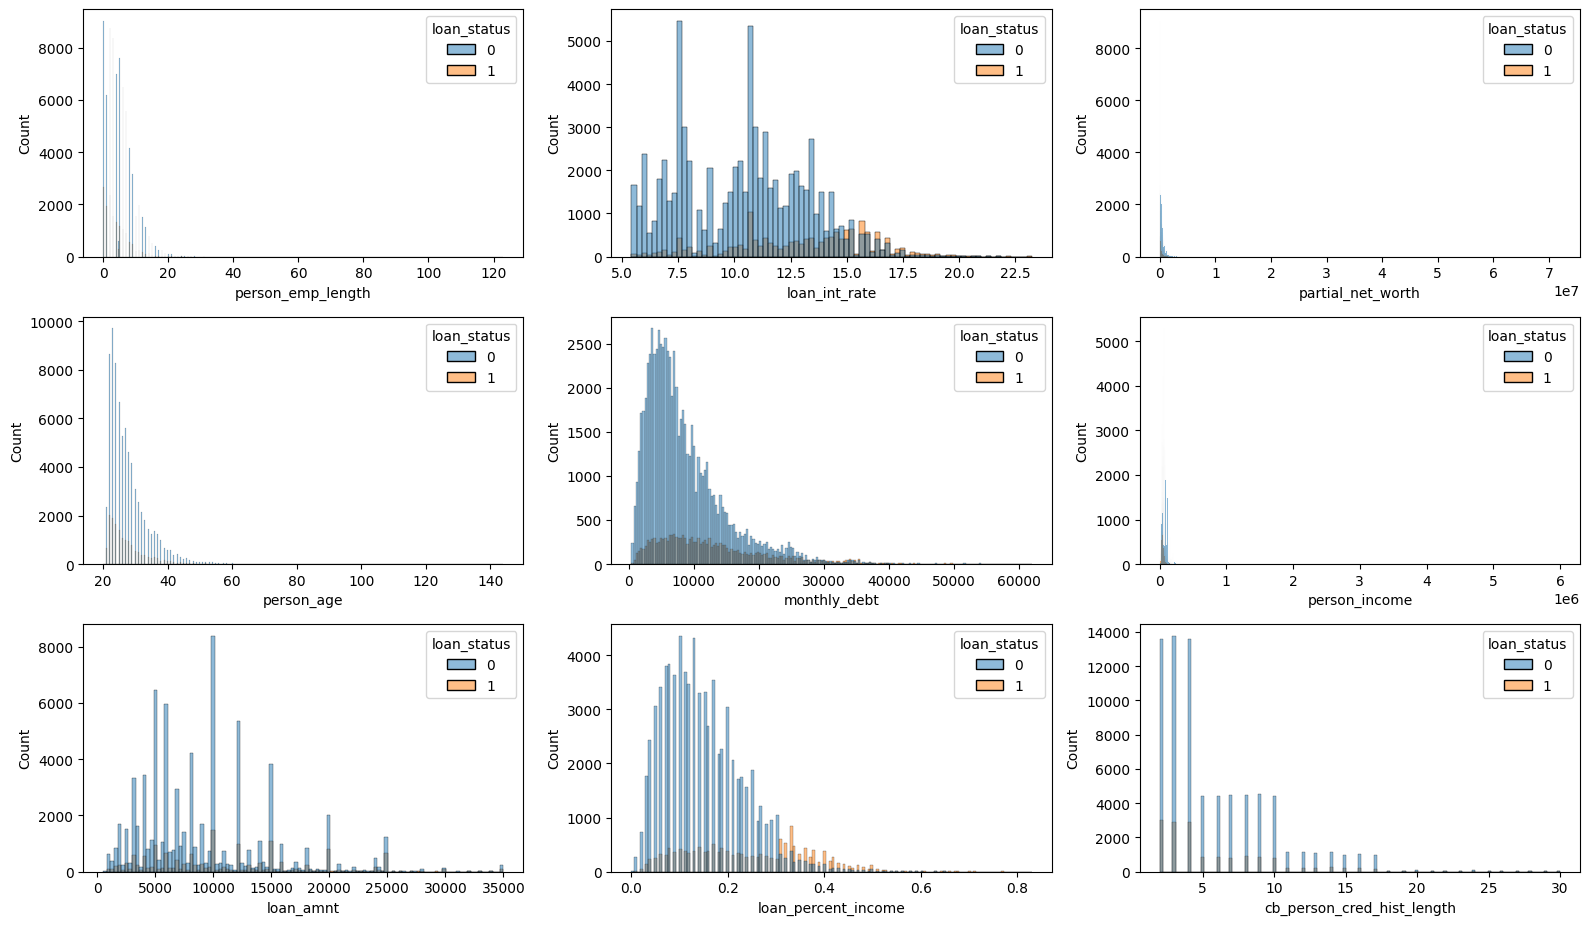

In [ ]:
plt.figure(figsize=(16, 12))
for i,col in enumerate(num_features):

  plt.subplot(4,3,i+1)

  sns.histplot(train_df, x=col, hue=target)

plt.tight_layout()
plt.show()

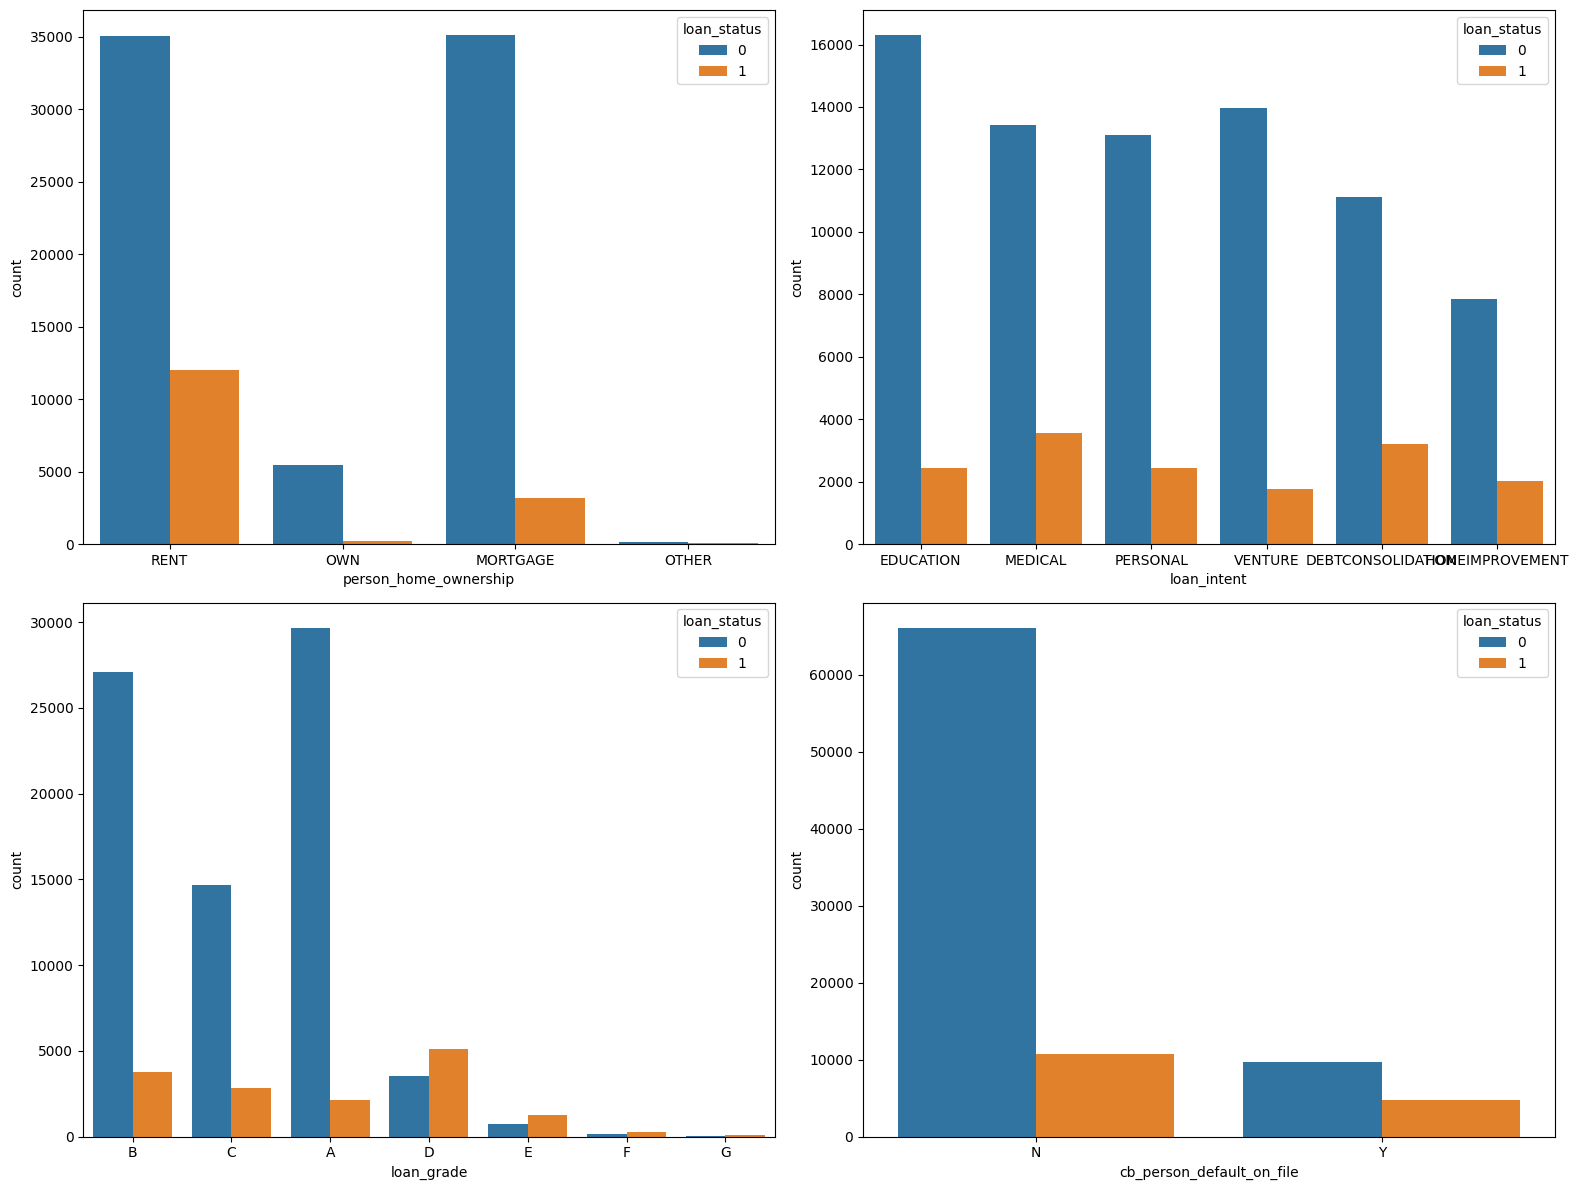

In [ ]:
plt.figure(figsize=(16, 12))
for i,col in enumerate(cat_features):
  plt.subplot(2,2,i+1)
  sns.countplot(train_df, x=col, hue=target)

plt.tight_layout()
plt.show()

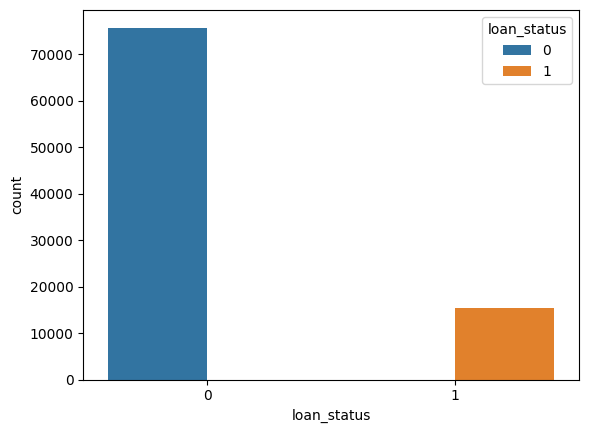

In [ ]:
sns.countplot(train_df, x=target, hue=target)
plt.show()

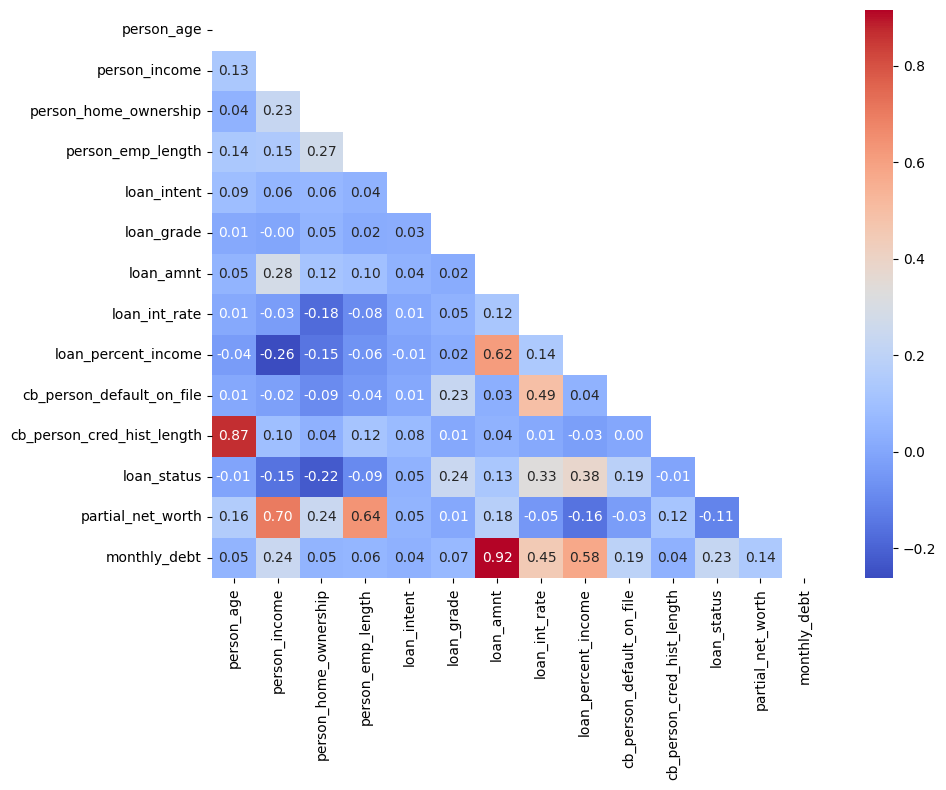

In [ ]:
train_new = train_df.copy()

for col in cat_features:
    train_new[col], _ = train_new[col].factorize()

cor_mat = train_new.corr()
mask = np.triu(cor_mat)

plt.figure(figsize=(10, 8))
sns.heatmap(cor_mat, fmt='.2f', annot=True, mask=mask, cmap='coolwarm')
plt.tight_layout()
plt.show()

In [ ]:
# cv intialize
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [ ]:
# another function
def convert_to_string(df):
    df_cat = df.copy()
    df_cat = df_cat.fillna(0)
    for col in features:
        df_cat[col] = df_cat[col].astype('string')
    return df_cat

In [ ]:
# Defining our X and y
X = train_df.drop('loan_status', axis=1)
y = target.ravel()

In [24]:
# CATB predictor - using GPU however catboot is still not fully optimised for GPUs so AUCs will still run on CPU
import torch
# Variables to store out-of-fold (OOF) predictions and feature importances
oof_preds = []
oof_aucs = []
oof_train_preds = np.zeros(len(y))

feature_importance_df = pd.DataFrame()  # DataFrame to store feature importances

cat_params = {
    'task_type': "GPU" if torch.cuda.is_available() else "CPU",
    #'devices': '0,
    'loss_function': 'Logloss',
    'eval_metric': "AUC",
    'bagging_temperature': 0.25,
    'iterations': 10000,
    'learning_rate': 0.045,
    'max_depth': 7,
    'l2_leaf_reg': 0.80,
    'min_data_in_leaf': 30,
    'random_strength': 0.25,
    'random_state': 42,
    'early_stopping_rounds': 200,
    'use_best_model': True,
    'allow_writing_files': False,
}

X_cat = convert_to_string(X)
test_cat = convert_to_string(test_df)

test_pool = Pool(test_cat, cat_features=features)

# Initialize to store one model for feature importance
best_cat_clf = None

for fold, (train_idx, test_idx) in enumerate(skfold.split(X_cat, y)):
    X_train, y_train = X_cat.iloc[train_idx], y[train_idx]
    X_test, y_test = X_cat.iloc[test_idx], y[test_idx]

    X_train_pool = Pool(X_train, y_train, cat_features=features)
    X_test_pool = Pool(X_test, y_test, cat_features=features)

    cat_clf = CatBoostClassifier(**cat_params)
    cat_clf = cat_clf.fit(X=X_train_pool, eval_set=X_test_pool, verbose=0, early_stopping_rounds=200)


    # Out-of-fold predictions
    oof_train_preds[test_idx] = cat_clf.predict_proba(Pool(X_test, cat_features=features))[:, 1]
    test_pred = cat_clf.predict_proba(test_pool)[:, 1]

    # Save feature importance for this fold
    fold_importance = cat_clf.get_feature_importance(Pool(X_test, cat_features=features))

    # Store fold importances in a DataFrame
    fold_importance_df = pd.DataFrame({
        'feature': features,
        f'importance_fold_{fold + 1}': fold_importance
    })

    # If it's the first fold, keep both 'feature' and importance
    if fold == 0:
        feature_importance_df = fold_importance_df
    else:
        # Concatenate only the importance columns for subsequent folds
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df[f'importance_fold_{fold + 1}']], axis=1)

    oof_preds.append(test_pred)
    auc = cat_clf.best_score_['validation']['AUC']
    oof_aucs.append(auc)
    print(f"\nFold {fold+1} --> ROC-AUC Score: {auc:.6f}\n")

    # Save the best model for feature importance
    if best_cat_clf is None or auc > max(oof_aucs):
        best_cat_clf = cat_clf

    del X_train, y_train, X_test, y_test
    del X_train_pool, X_test_pool
    del cat_clf
    gc.collect()

# Calculate the mean feature importance across folds
importance_cols = [col for col in feature_importance_df.columns if 'importance_fold' in col]
feature_importance_df['mean_importance'] = feature_importance_df[importance_cols].mean(axis=1)

# Select the top 10 features by mean importance
top_features = feature_importance_df.nlargest(6, 'mean_importance')

# Plot the top 10 important features
plt.figure(figsize=(5, 3))
sns.barplot(x='mean_importance', y='feature', data=top_features)
plt.title('Top 6 Feature Importance (CatBoost)')
plt.xlabel('Mean Importance')
plt.ylabel('Feature')
plt.show()

# Average and standard deviation of AUCs
auc_mean = np.mean(oof_aucs)
mean_auc_scores['cat'] = auc_mean
auc_std = np.std(oof_aucs)
print(f"\nAverage Fold ROC-AUC Score: {auc_mean:.6f} ± {auc_std:.6f}\n")

train_preds['cat'] = oof_train_preds
test_pred_cat = np.mean(oof_preds, axis=0)
test_preds['cat'] = test_pred_cat

SyntaxError: unterminated string literal (detected at line 12) (<ipython-input-24-ff149fe7690f>, line 12)

In [ ]:
test_preds_df = pd.DataFrame(test_preds)
train_preds_df = pd.DataFrame(train_preds)

In [ ]:
sub = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')
sub['loan_status'] = test_preds_df['cat']
csv_str = 'Submission.csv'
sub.to_csv(csv_str, index=False)